# Functions for processing brain scans

In [14]:
# Projection code sharing
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import nibabel as nib
from scipy.interpolate import RegularGridInterpolator as rgi


def get_labels(annotations_path):
    """
    Obtains Labels associated with vertices of the annotations file

    Parameters:
    - path: Anotations file path

    Returns:
    - labels: list of labels for each vertex
    """
    annot_data = nib.freesurfer.io.read_annot(annotations_path)
    labels = annot_data[0]
    return labels


def compute_extmat(mesh):
    """
    Compute the external transformation matrix (extmat) for a 3D mesh.

    This function calculates the external transformation matrix `extmat` for
    a 3D mesh, which can be used for various transformations such as centering
    and scaling the mesh.

    Parameters:
    - mesh (o3d.t.geometry.TriangleMesh): The 3D triangle mesh to compute the
      external transformation matrix for.

    Returns:
    - extmat (numpy.ndarray): A 4x4 transformation matrix represented as a
      NumPy array.
    """
    # Calculate the minimum and maximum corners of the mesh's bounding box.
    corner1 = np.min(mesh.vertex.positions.numpy(), axis=0)
    corner2 = np.max(mesh.vertex.positions.numpy(), axis=0)

    # Calculate the midpoint of the bounding box.
    midpoint = (corner1 + corner2) / 2

    # Create an identity 4x4 transformation matrix.
    extmat = np.eye(4)

    # Modify the diagonal elements and the last column of the matrix.
    np.fill_diagonal(extmat, [-1, 1, 1, 1])
    extmat[:,-1] = [-midpoint[0], -midpoint[1], -7.5 * corner1[2], 1]


    return extmat

def compute_intmat(img_width, img_height):
    """
    Compute the intrinsic matrix (intmat) for a camera with given image dimensions.

    Parameters:
    - img_width (int): The width of the camera image in pixels.
    - img_height (int): The height of the camera image in pixels.

    Returns:
    - intmat (numpy.ndarray): A 3x3 intrinsic matrix represented as a NumPy array.
    """
    # Create an identity 3x3 intrinsic matrix
    intmat = np.eye(3)

    # Fill the diagonal elements with appropriate values
    np.fill_diagonal(intmat, [-(img_width + img_height) / 1, -(img_width + img_height) / 1, 1])

    # Set the last column of the matrix for image centering
    intmat[:,-1] = [img_width / 2, img_height / 2, 1]

    return intmat

def create_mesh(mesh_path, perturb_vertices = True, std_dev = 0.1):
    """
    Create a 3D triangle mesh from a FreeSurfer surface file.

    This function reads a FreeSurfer surface file from the specified `mesh_path`,
    processes the vertex and face data, and constructs a 3D triangle mesh.

    Parameters:
    - mesh_path (str): The path to the FreeSurfer surface file to be processed.

    Returns:
    - mesh (o3d.t.geometry.TriangleMesh): A 3D triangle mesh representation of
      the input FreeSurfer surface.

    Dependencies: nibabel (nib), numpy (np), open3d (o3d)
    """
    # Read the FreeSurfer surface file and retrieve vertices, faces, and metadata.
    vertices, faces, info = nib.freesurfer.read_geometry(mesh_path, read_metadata=True)

    # Center the vertices around the origin.
    vertices = vertices - np.mean(vertices, axis=0)

    # Reorder the vertex columns for compatibility with open3d.
    vertices = vertices[:, [2, 0, 1]]

    # Create a 3D triangle mesh using open3d.
    mesh = o3d.t.geometry.TriangleMesh(o3d.core.Tensor(np.float32(vertices)),
                                       o3d.core.Tensor(np.int64(faces)))        
    
    # Compute vertex normals and triangle normals for the mesh.
    mesh.compute_vertex_normals()
    mesh.compute_triangle_normals()
    return mesh

def generate_maps(mesh, labels, intmat, extmat, img_width, img_height, rotation_matrices, recompute_normals):
    """
    Generate the output map based on ray casting and mesh properties.
    views are in this order ALWAYS = ['Front', 'Bottom', 'Top', 'Right', 'Back', 'Left']

    Parameters:
    - mesh (o3d.t.geometry.TriangleMesh): The 3D triangle mesh to cast rays onto.
    - labels (numpy.ndarray): The labels associated with the vertices of the mesh.
    - intmat (numpy.ndarray): A 3x3 intrinsic matrix for camera calibration.
    - extmat (numpy.ndarray): A 4x4 external transformation matrix for camera pose.
    - img_width (int): The width of the camera image in pixels.
    - img_height (int): The height of the camera image in pixels.

    Returns:
    - output_maps(6, 1080, 1920, 3), labels_maps((6, 1080, 1920), ids_maps(6, 1080, 1920), vertex_maps(6, 1080, 1920,3)

    Notes:
    - This function performs ray casting on the provided mesh using the given
      camera parameters and computes an output map based on the cast rays.

    Example:
    >>> mesh = create_mesh("example_mesh.surf")
    >>> labels = get_labels(annotations_path)
    >>> intmat = compute_intmat(1920, 1080)
    >>> extmat = compute_extmat(mesh)
    >>> width = 1920
    >>> height = 1080
    >>> output_map, labels_map = generate_output_map(mesh, intmat, extmat, width, height)
    >>> print(output_map)
    >>> print(labels_map)

    """

    # Validate parameters using assert statements
    assert isinstance(mesh, o3d.t.geometry.TriangleMesh), "mesh should be of type o3d.t.geometry.TriangleMesh"
    assert isinstance(labels, np.ndarray), "labels should be a 1-D NumPy array"
    expected_shape = (mesh.vertex.normals.shape[0],)
    assert labels.shape == expected_shape, f"labels should have the shape {expected_shape} which is the number of vertices, but got {labels.shape}"    
    assert isinstance(intmat, np.ndarray) and intmat.shape == (3, 3), "intmat should be a 3x3 NumPy array"
    assert isinstance(extmat, np.ndarray) and (extmat.shape == (1, 4, 4) or extmat.shape == (6, 4, 4)), "extmat should be a 4x4 or 6x4x4 NumPy array"
    assert isinstance(img_width, int) and img_width > 0, "img_width should be a positive integer"
    assert isinstance(img_height, int) and img_height > 0, "img_height should be a positive integer"

    # Create a RaycastingScene and add the mesh to it
    # Assuming 'View' argument will never be 'All':
    if recompute_normals == True:
        mesh.vertex.normals = mesh.vertex.normals@np.transpose(rotation_matrices[0][:3,:3].astype(np.float32))
        mesh.triangle.normals = mesh.triangle.normals@np.transpose(rotation_matrices[0][:3,:3].astype(np.float32))
        
    scene = o3d.t.geometry.RaycastingScene()
    scene.add_triangles(mesh)

    output_maps = []
    labels_maps = []
    ids_maps = []
    vertex_maps = []

    # rotation_matrices = compute_rotations(random_degs=7, view = view) Given as an argument
    for i in range(rotation_matrices.shape[0]): # TO DO - DONE: ROTATION MATRICES IS NOT DEFINED INSIDE THIS FUNCTION
        # Create rays using pinhole camera model
        rays = scene.create_rays_pinhole(intmat, extmat[i], img_width, img_height)
    
        # Cast rays and retrieve primitive IDs, hit distances, and normals
        cast = scene.cast_rays(rays)
        ids_map = np.array(cast['primitive_ids'].numpy(), dtype=np.int32)
        ids_maps.append(ids_map)
        hit_map = np.array(cast['t_hit'].numpy(), dtype=np.float32)
        weights_map = np.array(cast['primitive_uvs'].numpy(), dtype=np.float32)
        missing_weight = 1 - np.sum(weights_map, axis=2, keepdims=True)
        label_ids = np.argmax(np.concatenate((weights_map, missing_weight), axis=2), axis=2)
        
        # Compute the normal map
        normal_map = np.array(mesh.triangle.normals[ids_map.clip(0)].numpy(), dtype=np.float32)
        normal_map[ids_maps[i] == -1] = [0, 0, -1]
        normal_map[:, :, -1] = -normal_map[:, :, -1].clip(-1, 0)
        normal_map = normal_map * 0.5 + 0.5
    
        # Compute the vertex map
        vertex_map = np.array(mesh.triangle.indices[ids_map.clip(0)].numpy(), dtype=np.int32)
        vertex_map[ids_map == -1] = [-1]
        vertex_maps.append(vertex_map)
    
        # Compute the inverse distance map
        inverse_distance_map = 1 / hit_map
    
        # Compute the coded map with inverse distance
        coded_map_inv = normal_map * inverse_distance_map[:, :, None]
    
        # Normalize the output map
        output_map = (coded_map_inv - np.min(coded_map_inv)) / (np.max(coded_map_inv) - np.min(coded_map_inv))
        output_maps.append(output_map)
    
        # Compute the labels map
        labels_map = labels[vertex_map.clip(0)]
        labels_map[vertex_map == -1] = -1
        #labels_map = np.median(labels_map, axis=2)
        labels_map = labels_map[np.arange(labels_map.shape[0])[:, np.newaxis], np.arange(labels_map.shape[1]), label_ids]
        labels_map = labels_map.astype('float64')
        labels_maps.append(labels_map)

    output_maps = np.array(output_maps)
    labels_maps = np.array(labels_maps)
    #print('Type: ',labels_maps.dtype)
    # ids_maps = np.array(ids_maps)
    # vertex_maps = np.array(vertex_maps)
    
    return output_maps, labels_maps
    # return output_maps, labels_maps, ids_maps, vertex_maps

def create_pitch_rotation_matrix(pitch_angle):
    """
    Create a rotation matrix for pitch rotation.

    Parameters:
    - pitch_angle: Angle in radians for pitch rotation.

    Returns:
    - R_pitch: Rotation matrix for pitch.
    """
    R_pitch = np.array([[1, 0, 0, 0],
                        [0, np.cos(pitch_angle), -np.sin(pitch_angle), 0],
                        [0, np.sin(pitch_angle), np.cos(pitch_angle), 0],
                        [0, 0, 0, 1]])
    return R_pitch

def create_yaw_rotation_matrix(yaw_angle):
    """
    Create a rotation matrix for yaw rotation.

    Parameters:
    - yaw_angle: Angle in radians for yaw rotation.

    Returns:
    - R_yaw: Rotation matrix for yaw.
    """
    R_yaw = np.array([[np.cos(yaw_angle), 0, np.sin(yaw_angle), 0],
                      [0, 1, 0, 0],
                      [-np.sin(yaw_angle), 0, np.cos(yaw_angle), 0],
                      [0, 0, 0, 1]])
    return R_yaw

def create_roll_rotation_matrix(roll_angle):
    """
    Create a rotation matrix for roll rotation.

    Parameters:
    - roll_angle: Angle in radians for roll rotation.

    Returns:
    - R_roll: Rotation matrix for roll.
    """
    R_roll = np.array([[np.cos(roll_angle), -np.sin(roll_angle), 0, 0],
                       [np.sin(roll_angle), np.cos(roll_angle), 0, 0],
                       [0, 0, 1, 0],
                       [0, 0, 0, 1]])
    return R_roll

def compute_rotations(random_degs=5, view = 'Random', random = False):
    """
    Compute six random 3D rotation matrices for Front, Top, Bottom, Left, Back, Right views in this order
    with randomized small rotations from -3 to +3 degrees.

    Returns:
    - rotation_matrices (list of numpy.ndarray): A list containing six 4x4
      rotation matrices represented as NumPy arrays.

    Notes:
    - The rotation matrices are created based on random pitch and yaw angles
      with small random variations.
    """
    
    # Initialize an empty list to store the rotation matrices
    rotation_matrices = []

    if view == 'Random_6':
        # Select a random view from the available options
        available_views = ['Front', 'Bottom', 'Top', 'Right', 'Back', 'Left']
        view = np.random.choice(available_views)
        
    if view == 'All':
        # Define the pitch angles (Front, Bottom, Top) and add random variations
        pitch_angles = [0, 90, 270]
        pitch_angles = np.deg2rad(pitch_angles + np.random.uniform(-random_degs, random_degs, len(pitch_angles)))
        
        # Define the yaw angles (Right, Back, Left) and add random variations
        yaw_angles = [90, 180, 270]
        yaw_angles = np.deg2rad(yaw_angles + np.random.uniform(-random_degs, random_degs, len(yaw_angles)))
        
        # Loop through each pitch angle in radians and create the rotation matrix
        for angle in pitch_angles:
            R_pitch = create_pitch_rotation_matrix(angle)
            R = (R_pitch 
                 @ create_yaw_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))) 
                 @ create_roll_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))))
            
            rotation_matrices.append(R)
            
        # Loop through each yaw angle in radians and create the rotation matrix
        for angle in yaw_angles:
            R_yaw = create_yaw_rotation_matrix(angle)
            R = (R_yaw 
                 @ create_pitch_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))) 
                 @ create_roll_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))))
            rotation_matrices.append(R)

    elif view == 'Front': # Set this to recompute normals on the fly
        angle = np.deg2rad(np.random.uniform(-random_degs, random_degs))
        R = create_pitch_rotation_matrix(angle)
        R =  (create_pitch_rotation_matrix(angle)
             @ create_yaw_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))) 
             @ create_roll_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))))
        rotation_matrices.append(R)

    elif view == 'Bottom':
        angle = np.deg2rad(90 + np.random.uniform(-random_degs, random_degs))
        R =  (create_pitch_rotation_matrix(angle)
             @ create_yaw_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))) 
             @ create_roll_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))))
        rotation_matrices.append(R)

    elif view == 'Top':
        angle = np.deg2rad(270 + np.random.uniform(-random_degs, random_degs))
        R =  (create_pitch_rotation_matrix(angle)
             @ create_yaw_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))) 
             @ create_roll_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))))
        rotation_matrices.append(R)

    elif view == 'Right':
        angle = np.deg2rad(90 + np.random.uniform(-random_degs, random_degs))
        R = (create_yaw_rotation_matrix(angle) 
             @ create_pitch_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))) 
             @ create_roll_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))))
        rotation_matrices.append(R)

    elif view == 'Back':
        angle = np.deg2rad(180 + np.random.uniform(-random_degs, random_degs))
        R = (create_yaw_rotation_matrix(angle) 
             @ create_pitch_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))) 
             @ create_roll_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))))
        rotation_matrices.append(R)
    elif view == 'Left':
        angle = np.deg2rad(270 + np.random.uniform(-random_degs, random_degs))
        R = (create_yaw_rotation_matrix(angle) 
             @ create_pitch_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))) 
             @ create_roll_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))))
        rotation_matrices.append(R)
        
    elif view == 'Random':
        R = (create_yaw_rotation_matrix(-np.pi + 2 * np.pi * np.random.rand()) 
             @ create_pitch_rotation_matrix(-np.pi + 2 * np.pi * np.random.rand()) 
             @ create_roll_rotation_matrix(-np.pi + 2 * np.pi * np.random.rand())) 
        rotation_matrices.append(R)
    rotation_matrices = np.array(rotation_matrices)

    
    #rotation_matrices = np.transpose(rotation_matrices, (1, 2, 0))

    return rotation_matrices

def predict_segmentation(vertices, faces, output_maps, ids_maps_o, weights_maps_full_o, probs):
    """
    Calculate Lhat based on input data.

    Args:
    vertices (numpy.ndarray): Vertices.
    output_maps (list): List of output maps.
    ids_maps_o (list): List of ids maps.
    weights_maps_full_o (list): List of full weights maps.
    probs (list): List of probabilities.
    Returns:
    numpy.ndarray: Lhat array.
    """
    print('Agregating predicted labels...')
    NV = len(vertices)
    NL = 37
    P = np.zeros([NL, NV])
    # P[0, :] = 1e-6
    touched = np.zeros(NV)

    for ids_map, weights_map_full, prob in zip(ids_maps_o, weights_maps_full_o, probs):
        view = prob  # Shape is 37,800,800
        weights_map_full = weights_map_full

        vert_idx = faces[ids_map]  # Shape is 800, 800, 3

        for v in range(3):
            v_map = vert_idx[:, :, v][np.newaxis, ...]  # Shape is 1, 800, 800
            w_map = weights_map_full[:, :, v][np.newaxis, ...]
            s_map = view
            ws_map = s_map * w_map  # Shape is 37, 800, 800

            for i in range(800):
                for j in range(800):
                    v_idx = v_map[0, i, j]
                    P[:, v_idx] += ws_map[:, i, j]
                    touched[v_idx] = 1

    Lhat = np.argmax(P, axis=0)
    Lhat -= 1
    # P /= np.sum(P, axis=0)[np.newaxis, :]
    print('Labels aggregated!')

    return Lhat, P

def compute_output_maps(mesh, img_width, img_height):
    a = mesh.vertex.positions.cpu().numpy().copy()
    b = mesh.vertex.normals.cpu().numpy().copy()
    a /= np.sqrt(np.sum(a*a, axis=1))[:, np.newaxis]
    dot = np.sum(a * b, axis=1)
    
    if np.mean(dot) < 0:
        mesh.vertex.normals[:, 0] *= -1
        mesh.triangle.normals[:, 0] *= -1
        mesh.vertex.normals[:, 1] *= -1
        mesh.triangle.normals[:, 1] *= -1
        mesh.vertex.normals[:, 2] *= -1
        mesh.triangle.normals[:, 2] *= -1

    rotation_matrices = compute_rotations(view='All')
    v_n = mesh.vertex.normals
    t_n = mesh.triangle.normals
    output_maps = []
    ids_maps_o = []
    weights_maps_full_o = []
    extmats = []

    intmat = compute_intmat(img_width, img_height)
    extmat = compute_extmat(mesh)

    scene = o3d.t.geometry.RaycastingScene()
    scene.add_triangles(mesh)

    for i, rotation_matrix in enumerate(rotation_matrices): 
        extmats.append(np.matmul(extmat, rotation_matrix))

    for i in range(rotation_matrices.shape[0]): 
        mesh.vertex.normals = v_n @ np.transpose(rotation_matrices[i][:3,:3].astype(np.float32))
        mesh.triangle.normals = t_n @ np.transpose(rotation_matrices[i][:3,:3].astype(np.float32))
        rays = scene.create_rays_pinhole(intmat, extmats[i], img_width, img_height)

        cast = scene.cast_rays(rays)
        ids_map = np.array(cast['primitive_ids'].numpy(), dtype=np.int32)
        ids_maps_o.append(ids_map)
        hit_map = np.array(cast['t_hit'].numpy(), dtype=np.float32)
        weights_map = np.array(cast['primitive_uvs'].numpy(), dtype=np.float32)
        missing_weight = 1 - np.sum(weights_map, axis=2, keepdims=True)
        weights_map_full = np.concatenate((weights_map, missing_weight), axis=2)
        weights_maps_full_o.append(weights_map_full)
        label_ids = np.argmax(np.concatenate((weights_map, missing_weight), axis=2), axis=2)

        normal_map = np.array(mesh.triangle.normals[ids_map.clip(0)].numpy(), dtype=np.float32)
        normal_map[ids_maps_o[i] == -1] = [0, 0, -1]
        normal_map[:, :, -1] = -normal_map[:, :, -1].clip(-1, 0)
        normal_map = normal_map * 0.5 + 0.5

        vertex_map = np.array(mesh.triangle.indices[ids_map.clip(0)].numpy(), dtype=np.int32)
        vertex_map[ids_map == -1] = [-1]

        inverse_distance_map = 1 / hit_map
        coded_map_inv = normal_map * inverse_distance_map[:, :, None]
        output_map = (coded_map_inv - np.min(coded_map_inv)) / (np.max(coded_map_inv) - np.min(coded_map_inv))
        output_maps.append(output_map)

    return np.array(output_maps), ids_maps_o, weights_maps_full_o

In [21]:
mesh = create_mesh("Data/100206/surf/lh_aligned.surf")
labels = get_labels("Data/100206/label/lh.annot")
intmat = compute_intmat(1920, 1080)
extmat = compute_extmat(mesh).reshape(1, 4, 4)
width = 1920
height = 1080
R_matrices = compute_rotations(view = "All")

# output_maps, labels_maps = generate_maps(mesh, labels, intmat, extmat, width, height, R_matrices, True)

In [22]:
print(R_matrices)

[[[ 9.94802254e-01 -5.49502187e-02  8.57260057e-02  0.00000000e+00]
  [ 5.12159003e-02  9.97665574e-01  4.51700549e-02  0.00000000e+00]
  [-8.80079891e-02 -4.05447379e-02  9.95294287e-01  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99627744e-01 -2.72307813e-02  1.69063121e-03  0.00000000e+00]
  [ 2.01869021e-04 -5.45822402e-02 -9.98509258e-01  0.00000000e+00]
  [ 2.72824657e-02  9.98137898e-01 -5.45564246e-02  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.97752255e-01 -5.66186412e-02  3.58436399e-02  0.00000000e+00]
  [-3.95120962e-02 -6.50604496e-02  9.97098757e-01  0.00000000e+00]
  [-5.41223734e-02 -9.96273791e-01 -6.71513316e-02  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 3.89532318e-03  3.02214535e-02  9.99535637e-01  0.00000000e+00]
  [-7.96396285e-02  9.96377719e-01 -2.98156061e-02  0.00000000e+00]
  [-9.96816109e-01 -7.94865054e-02  6.2880

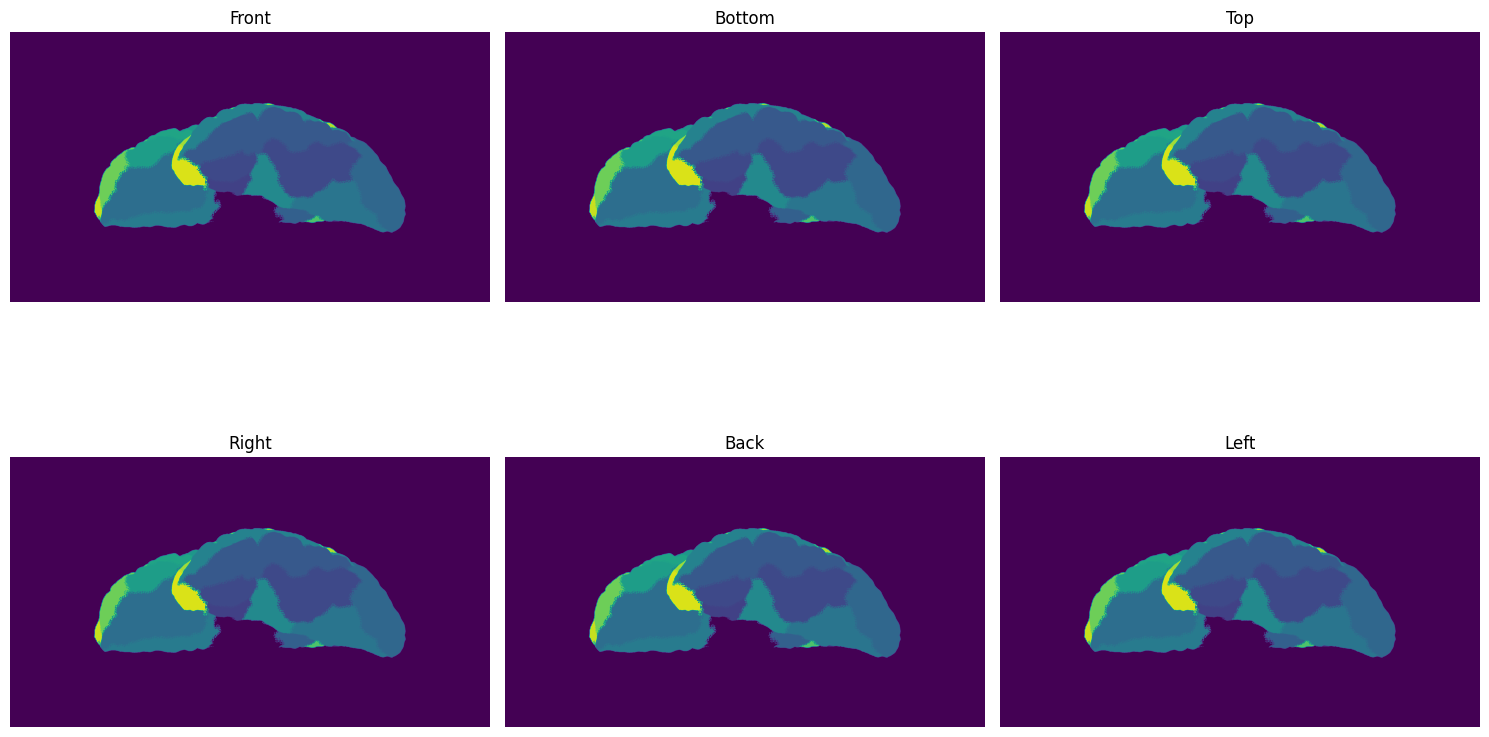

In [17]:
# Assuming 'views' is correct, proceed to visualization
views = ['Front', 'Bottom', 'Top', 'Right', 'Back', 'Left']

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    
for i, ax in enumerate(axs.flatten()): 
    ax.imshow(labels_maps.reshape(height, width), cmap='viridis')  # Display the labels map
    ax.set_title(views[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# output_map_2d = output_map.reshape(-1, 3)
# output_map_2d = output_map_2d.astype(np.float64)
# mesh_legacy = mesh.to_legacy()
# mesh_legacy.vertex_colors = o3d.utility.Vector3dVector(output_map_2d)
# o3d.visualization.draw_geometries([mesh_legacy])